In [11]:
import requests
from pathlib import Path
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data_path = Path("data/")
train_path = data_path / "train"

if train_path.is_dir():
  print(f"{train_path} directory already exists....skipping download")
else:
  print(f"{train_path} does not exist, creating one....")
  train_path.mkdir(parents = True, exist_ok = True)

with open(train_path / "train.csv", "wb") as f:
  request = requests.get("https://github.com/sriskid/Kaggle/raw/main/black_friday_prediction/train_oSwQCTC/train.csv")
  print("Downloading training data....")
  f.write(request.content)

data/train directory already exists....skippign download


In [58]:
train_data = pd.read_csv(train_path / "train.csv")

In [59]:
train_data

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,M,51-55,13,B,1,1,20,NaN,NaN,368
550064,1006035,P00375436,F,26-35,1,C,3,0,20,NaN,NaN,371
550065,1006036,P00375436,F,26-35,15,B,4+,1,20,NaN,NaN,137
550066,1006038,P00375436,F,55+,1,C,2,0,20,NaN,NaN,365


# Exploratory Data Analysis

## Initial Data Visualization

In [60]:
# Check for missign values
train_data.isnull().sum()
# The only missing values combe from product_category_2 and product_category_3

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [62]:
categorical_columns = train_data.select_dtypes(include=object).columns.tolist()
print(len(categorical_columns))

5


In [63]:
categorical_columns

['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

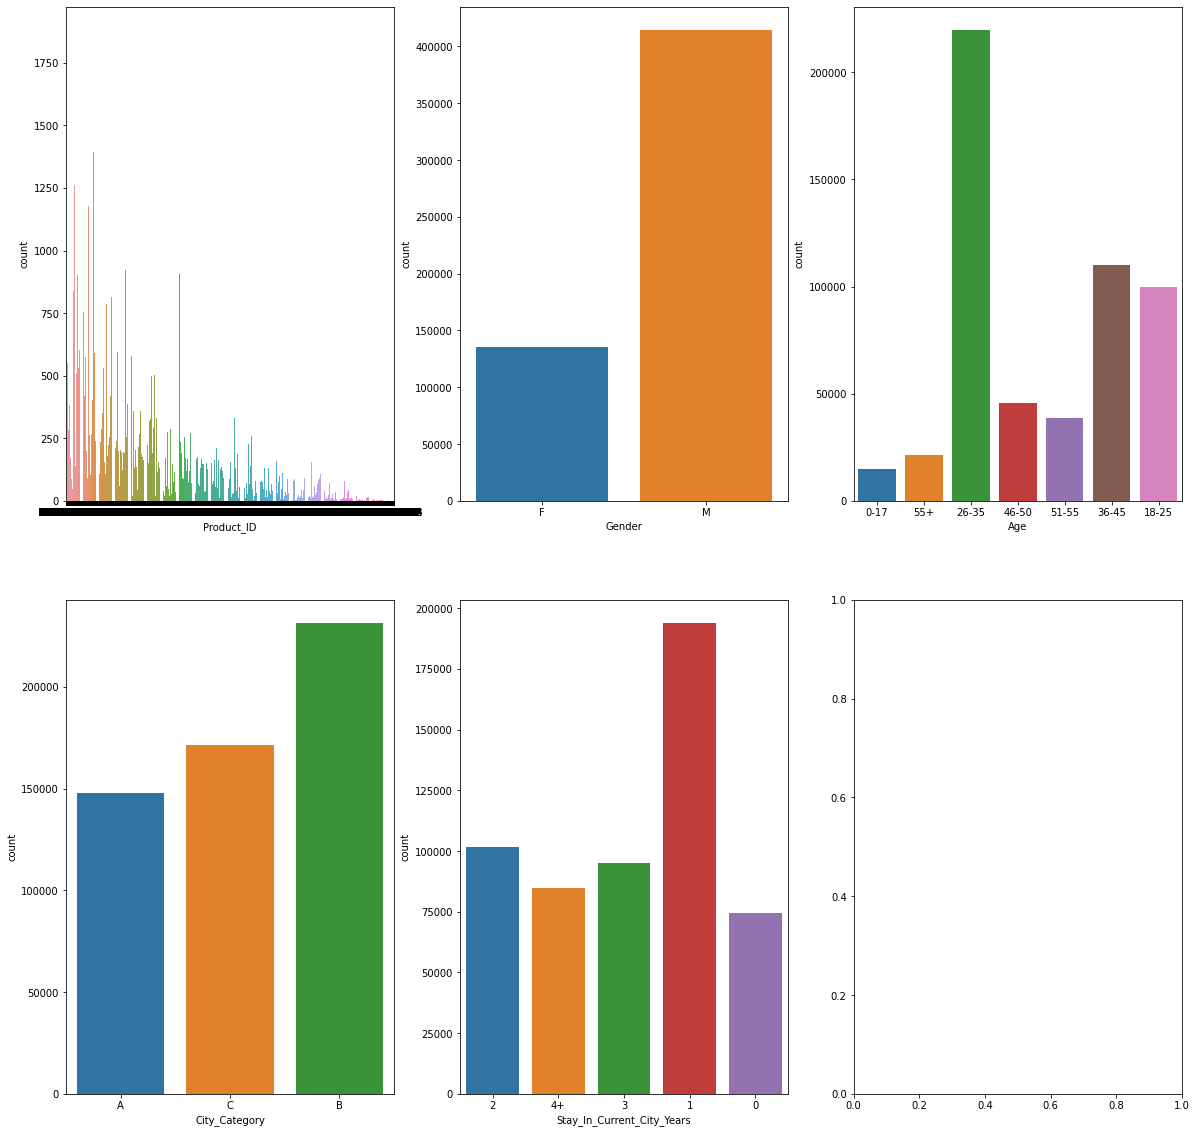

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
for i, column in enumerate(categorical_columns):
  sns.countplot(data = train_data, x = column, ax = axes[i // 3, i % 3])

From this plot we get a few useful pieces of information:


*   There are far more men purchasing items than women, this could be due to a few reasons, namely there are far more products that appeal to men than women, or the products being bought are on behalf of their spouse and therefore the appeal of the item itself may not be for them.

*   A huge number of purchases come from those age 26 - 35, meaning that the majority of products cater to this age range, or that they are buying for others. Furthermore, the age range with the least amount of purchasing are 0 - 17 and 55 +. This could be due to either the products not catering to them or that they are dependent on someone within the 26 - 35 range category to buy 
things for them

*   People from City C made more purchases
*   Poeple who have stayed in their city for a year made the most number of purchases





<AxesSubplot:xlabel='Gender', ylabel='count'>

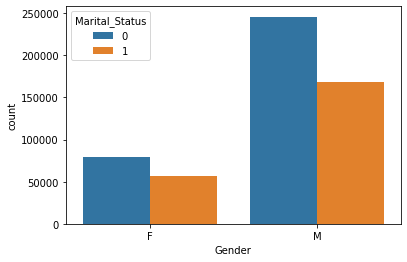

In [67]:
# Check the number of men making purchases based on their marital status
sns.countplot(data = train_data, x = "Gender", hue = "Marital_Status")

From the above plot, we see that men and women make fewer purchases where they are married versus when they are not married. However, regardless of whether married or not, men made more purchases. 

<AxesSubplot:xlabel='Age', ylabel='count'>

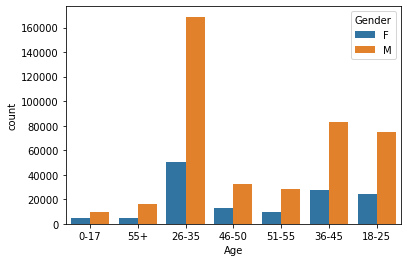

In [69]:
# Then in that case, let us check the age ranges that people are making purchases based on gender
sns.countplot(data = train_data, x = "Age", hue = "Gender")

From this plot, we see that overall men make more purchases than women. In the range of 26 - 35 we see a huge increase in the number of purchases by men. This could be due to buying items for themselves, their spouse, or their children.

<AxesSubplot:xlabel='Age', ylabel='count'>

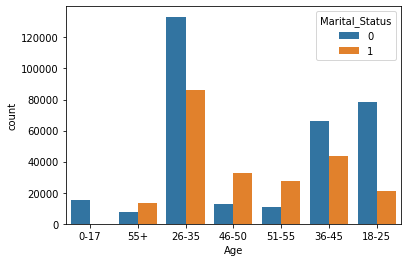

In [70]:
# Check the Age Ranges Based off Marital Status
sns.countplot(data = train_data, x = "Age", hue = "Marital_Status")

Looking at the breakdown of age ranges:


*   Obviously those of age range 0 - 17 are not going to be married
*   For the age range 26 - 35, those who are not married make more purchases
* Across all married age ranges, those who are 26 - 35 make the most number of purchases



<AxesSubplot:xlabel='Age', ylabel='Purchase'>

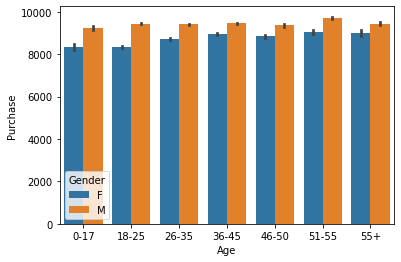

In [33]:
# Break down the ages by gender
sns.barplot(data = train_data, x = "Age", y = "Purchase", hue = "Gender")

The above plot shows that across all age ranges, men are spending the most 

<AxesSubplot:xlabel='Marital_Status', ylabel='Purchase'>

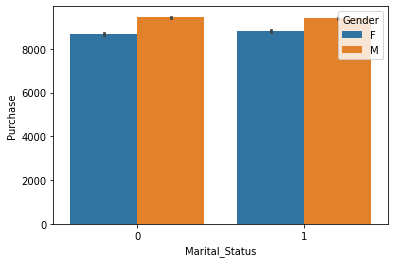

In [72]:
# Plot purchasing based on marital status
sns.barplot(data = train_data, x = "Marital_Status", y = "Purchase", hue = "Gender")

From the above we know that:


*   On average men, spend more whether they are married or not



<AxesSubplot:xlabel='Age', ylabel='Purchase'>

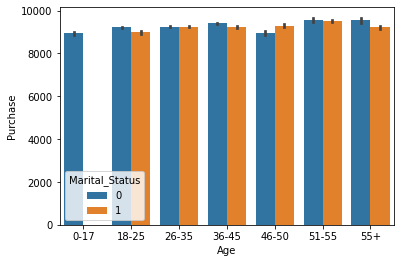

In [34]:
# Plot Purchase Amount Based on Age and discriminate based on Marital Status
sns.barplot(data = train_data, x = "Age", y = "Purchase", hue = "Marital_Status")

Across all age ranges (except for 0 - 17), we see that those who are married or not married spent about the same amount of money on average

<AxesSubplot:xlabel='City_Category', ylabel='Purchase'>

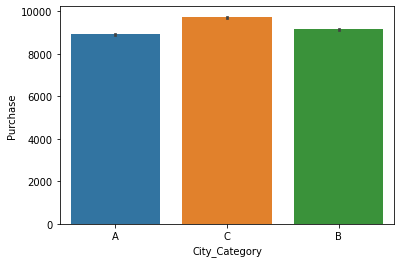

In [32]:
sns.barplot(data = train_data, x = "City_Category", y = "Purchase")

The above plot shows that people from City C spent the most

<AxesSubplot:xlabel='City_Category', ylabel='Purchase'>

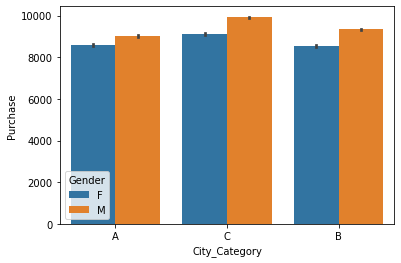

In [31]:
# Plot the purchase amount by city dividing by gender
sns.barplot(data = train_data, x = "City_Category", y = "Purchase", hue = "Gender")

If we break down the cities by gender, we see that specifically men from City C spent the most and that among all 3 cities, men spent the most.

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

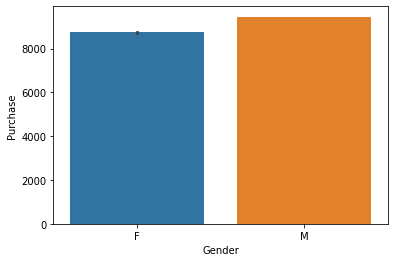

In [37]:
sns.barplot(data = train_data, x = "Gender", y = "Purchase")

As has been the case with the other plots, on average men spend more than women

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

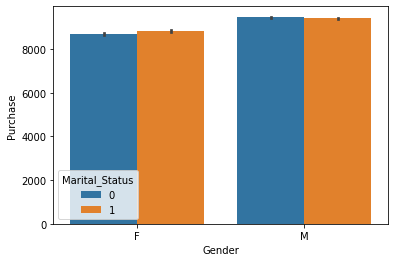

In [53]:
sns.barplot(data = train_data, x = "Gender", y = "Purchase", hue = "Marital_Status")

If we look at marital status, men and women spent roughly the same amount regardless of marital status, with men spending on average more. 

### Exploring Occupation

<AxesSubplot:xlabel='Occupation', ylabel='count'>

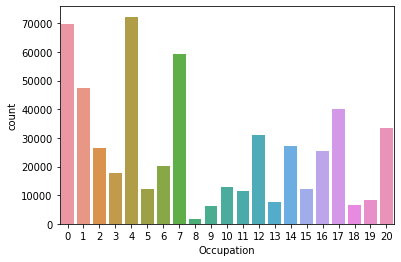

In [48]:
# Plot counts of the different occupations to see which occupation has the highest count
sns.countplot(x  = train_data["Occupation"])

From the above plot we see that those in occupation 0 and 4 appear the most in the data followed by those in occupation 3

<AxesSubplot:xlabel='Occupation', ylabel='count'>

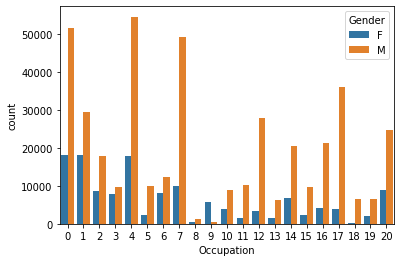

In [51]:
# Plot count of occupation based on gender
sns.countplot(x  = train_data["Occupation"], hue = train_data["Gender"])

Across almost all occupations, there are more men than women except for occupation 9.

<AxesSubplot:xlabel='Occupation', ylabel='Purchase'>

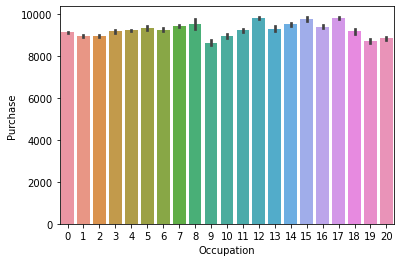

In [49]:
# Plot occupation to purchase amount
sns.barplot(data = train_data, x = "Occupation", y = "Purchase")

Overall across all occupations, the average purchase amount is relatively the same

<AxesSubplot:xlabel='Occupation', ylabel='Purchase'>

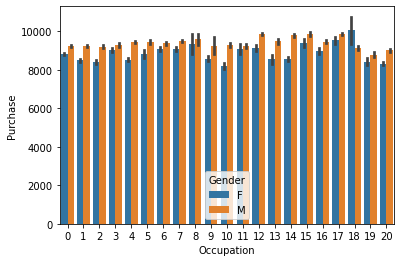

In [50]:
# What if we discriminated the occupations based on gender
sns.barplot(data = train_data, x = "Occupation", y = "Purchase", hue = "Gender")

Across almost all occupations, men on average purchased more than women, however in occupation 18, we see that women spent far more than men. Furthermore, we see that the difference between men and women in spending across the different occupations is not that much compared to the large discrepancy between the number of men and women across the occupations (Occupation 18 has far more men than women and Occupation 9 has far more women than men, however men still had on average higher purchases).

 ## Cleaning up the Data

Looking at the User_ID, of the data, we see that in some instances the same User_ID is making purchases, meaning that the customer is buying multiple items. We can filter the data to condense the unique User_IDs. 